# Fine-tuning EpiAgent for Supervised Cell Type Annotation on a New Dataset

In this notebook, we provide a detailed demonstration of how to fine-tune the **EpiAgent** model for **Supervised Cell Type Annotation (SCA)** on a newly sequenced single-cell ATAC-seq dataset. This demo showcases cross-validation on a single dataset, where we use two-thirds of the data for training and the remaining one-third for testing.

The **EpiAgent** model used in this notebook has been pre-trained on the large-scale **Human-scATAC-Corpus** comprising approximately **5 million cells** and **35 billion tokens**. Fine-tuning this model on your dataset can enhance its cell type annotation performance, leveraging the patterns learned from large-scale data.

**Prerequisites:**

- **EpiAgent Pre-trained Model**: `pretrained_EpiAgent.pth` (can be downloaded at https://drive.google.com/drive/folders/1WlNykSCNtZGsUp2oG0dw3cDdVKYDR-iX?usp=sharing)
- **Candidate cis-Regulatory Elements (cCREs)**: `cCRE.bed`  (can be downloaded at https://github.com/xy-chen16/EpiAgent/blob/main/data/cCRE.bed)
- **Sample Dataset**:

  - `Kanemaru2023_downsampled_10000_cells.h5ad`  (can be downloaded at https://drive.google.com/drive/folders/1WlNykSCNtZGsUp2oG0dw3cDdVKYDR-iX?usp=sharing): The downsampled Kanemaru2023 dataset with cell type annotations.

# Step 1: Data Loading and Preprocessing

In this step, we will load the **Kanemaru2023** dataset and perform the necessary preprocessing to prepare it for fine-tuning with EpiAgent. Since we are performing supervised learning and cross-validation, we need to split the dataset into training and test sets while preserving the cell type distributions.

**Preprocessing Steps:**

1. **Data Splitting**: Split the dataset into training and test sets (2/3 for training, 1/3 for testing) stratified by cell type.
2. **TF-IDF Transformation**: Convert discrete count data into continuous importance scores for accessible cCREs.
3. **Tokenization**: Generate `cell_sentences` to represent each cell as a sequence of accessible cCRE indices.
4. **Label Encoding**: Encode cell type labels into numerical format suitable for model training.

## Load the Dataset and Split into Training and Test Sets

In [1]:
import scanpy as sc
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset
input_path = '../data/sample/raw_h5ad/Kanemaru2023_downsampled_10000_cells.h5ad'
adata = sc.read_h5ad(input_path)

# Split the dataset into training and test sets, stratified by cell type
train_adata, test_adata = train_test_split(
    adata,
    test_size=0.33,
    stratify=adata.obs['cell_type'],
    random_state=42
)

print(f"Training set size: {train_adata.n_obs} cells")
print(f"Test set size: {test_adata.n_obs} cells")

Training set size: 6700 cells
Test set size: 3301 cells



## TF-IDF Transformation and Tokenization

To prepare the Kanemaru2023 dataset for EpiAgent, we perform the following preprocessing steps:

1. **TF-IDF Transformation**: Convert discrete count data into continuous importance scores for accessible cCREs.
2. **Tokenization**: Generate `cell_sentences` to represent each cell as a sequence of accessible cCRE indices.

**Note**: We need to load the cCRE document frequency data required for the TF-IDF transformation.

In [2]:
import numpy as np
from epiagent.tokenization import tokenization
from epiagent.preprocessing import global_TFIDF

# Load the cCRE document frequency data
cCRE_document_frequency = np.load('../data/cCRE_document_frequency.npy')

# Apply TF-IDF transformation to the training set
global_TFIDF(train_adata, cCRE_document_frequency)

# Perform tokenization on the training set to create cell sentences
tokenization(train_adata)

# Repeat the TF-IDF transformation and tokenization for the test set
global_TFIDF(test_adata, cCRE_document_frequency)
tokenization(test_adata)

/home/chenxiaoyang/program/scCASdata/Big model/epiagent/tokenization.py:52: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_sentences'] = pd.Series(cell_sentences, index=adata.obs.index)


Tokenization complete: 'cell_sentences' column added to adata.obs.
Tokenization complete: 'cell_sentences' column added to adata.obs.


/home/chenxiaoyang/program/scCASdata/Big model/epiagent/tokenization.py:52: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_sentences'] = pd.Series(cell_sentences, index=adata.obs.index)


## Encode Cell Type Labels

We need to encode the cell type labels into numerical format for model training.

In [3]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder on the training cell types and transform
train_adata.obs['cell_type_encoded'] = label_encoder.fit_transform(train_adata.obs['cell_type'])

# Transform the test cell types using the same encoder
test_adata.obs['cell_type_encoded'] = label_encoder.transform(test_adata.obs['cell_type'])

# Get the number of unique cell types (classes)
num_classes = len(label_encoder.classes_)
print(f"Number of cell type classes: {num_classes}")

Number of cell type classes: 12


# Step 2: Create Datasets and DataLoaders

In this step, we create PyTorch datasets and dataloaders required for training and inference. For training, we use the `CellDatasetForSCA` class, which includes both the tokenized cell sentences and the cell type labels.


## Create Training Dataset and DataLoader

In [4]:
from epiagent.dataset import CellDatasetForSCA, collate_fn_for_SCA
from torch.utils.data import DataLoader

# Extract cell sentences and labels from the training AnnData
train_cell_sentences = train_adata.obs['cell_sentences'].tolist()
train_cell_types = train_adata.obs['cell_type_encoded'].tolist()

# Create the training dataset
train_dataset = CellDatasetForSCA(
    cell_sentences=train_cell_sentences,
    cell_types=train_cell_types,
    max_length=8192,
    is_random=False
)

# Create the training DataLoader
train_batch_size = 5
train_dataloader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=16,
    collate_fn=collate_fn_for_SCA
)

## Create Test Dataset and DataLoader

For inference, we use the `CellDataset` class, which only requires the tokenized cell sentences.

In [5]:
from epiagent.dataset import CellDataset, collate_fn

# Extract cell sentences from the test AnnData
test_cell_sentences = test_adata.obs['cell_sentences'].tolist()

# Create the test dataset
test_dataset = CellDataset(
    cell_sentences=test_cell_sentences,
    max_length=8192,
    is_random=False
)

# Create the test DataLoader
test_batch_size = 8
test_dataloader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

# Step 3: Load the Pre-trained EpiAgent Model and Prepare for Supervised Fine-tuning

In this step, we use the defined `EpiAgent_supervised` model and initialize it with the pre-trained weights from the unsupervised EpiAgent model. We will transfer the matching parameters from the pre-trained model to the supervised model.


## Import the Necessary Modules and Define the `EpiAgent_supervised` Model

In [6]:
import torch
import torch.nn as nn
from epiagent.model import EpiAgent, EpiAgent_supervised

We are using the `EpiAgent_supervised` class defined in the `epiagent` package, which is designed for supervised cell type annotation tasks.

## Initialize the Supervised Model and Load Pre-trained Weights

In [7]:
# Specify the path to the pre-trained unsupervised model
pretrained_model_path = '../model/pretrained_EpiAgent.pth'

# Set the device (GPU if available)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the pre-trained EpiAgent model
pretrained_model = EpiAgent(
    vocab_size=1355449,
    num_layers=18,
    embedding_dim=512,
    num_attention_heads=8,
    max_rank_embeddings=8192,
    use_flash_attn=True,
    pos_weight_for_RLM=torch.tensor(1.0),
    pos_weight_for_CCA=torch.tensor(1.0)
)

# Load the pre-trained weights into the model
pretrained_model.load_state_dict(torch.load(pretrained_model_path))

<All keys matched successfully>

Now, we initialize the `EpiAgent_supervised` model with the appropriate number of classes (determined from the label encoder) and transfer the weights from the pre-trained model.

In [8]:
# Initialize the supervised EpiAgent model with the appropriate number of classes
from epiagent.model import EpiAgent_supervised

num_classes = len(label_encoder.classes_)

supervised_model = EpiAgent_supervised(
    vocab_size=1355449,
    num_layers=18,
    embedding_dim=512,
    num_attention_heads=8,
    max_rank_embeddings=8192,
    num_classes=num_classes,
    use_flash_attn=True
)

# Transfer matching weights from the pre-trained model to the supervised model
# This involves copying parameters with the same names
pretrained_state_dict = pretrained_model.state_dict()
supervised_state_dict = supervised_model.state_dict()

# Identify parameters that are common between the two models
common_params = {k: v for k, v in pretrained_state_dict.items() if k in supervised_state_dict and v.size() == supervised_state_dict[k].size()}

# Update the supervised model's state dict with pre-trained parameters
supervised_state_dict.update(common_params)

# Load the updated state dict into the supervised model
supervised_model.load_state_dict(supervised_state_dict)

# Set the device (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the supervised model to the specified device
supervised_model.to(device)

print("Supervised model initialized and pre-trained weights loaded.")

Supervised model initialized and pre-trained weights loaded.


**Explanation:**

- We first load the pre-trained EpiAgent model (`pretrained_model`) and its state dictionary.
- We initialize the `EpiAgent_supervised` model (`supervised_model`) with the same configurations and the number of classes (`num_classes`).
- To transfer the weights, we extract the state dictionaries of both models and identify parameters that share the same names and shapes.
- We update the supervised model's parameters with the pre-trained weights where possible.
- Finally, we load the updated state dictionary into the supervised model and move it to the device.

**Note:**

- This approach ensures that only the matching parameters are transferred. The classifier layers in the supervised model, which do not exist in the pre-trained unsupervised model, are initialized randomly.
- The `EpiAgent_supervised` model uses the same backbone architecture as `EpiAgent`, with the addition of a classifier head for cell type classification.


---

Now, we are ready to proceed to the fine-tuning step with the supervised model initialized appropriately.

---


# Step 4: Fine-tune the Supervised EpiAgent Model

We now fine-tune the supervised EpiAgent model using the prepared training data. The fine-tuning process adjusts the model weights to better capture the patterns specific to the new dataset for cell type classification.

In [9]:
from epiagent.train import fine_tune_epiagent_for_SCA

# Fine-tune the model
fine_tuned_model = fine_tune_epiagent_for_SCA(
    model=supervised_model,
    train_dataloader=train_dataloader,
    num_steps=100000,  # Total training steps
    save_dir='../model/fine_tune/SCA/demo_dataset/',
    device=device,
    learning_rate=1e-4,
    save_steps=20000,
    log_steps=500,
    warmup_steps=10000,
    is_logging=True
)

Model directory created at: ../model/fine_tune/SCA/demo_dataset/


/home/chenxiaoyang/anaconda3/envs/FM/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Step [500/100000], Classification Loss: 2.1784, Accuracy: 0.0820, Cohen's Kappa: -0.0143, Macro F1: 0.0537
Step [1000/100000], Classification Loss: 1.7626, Accuracy: 0.2260, Cohen's Kappa: 0.0854, Macro F1: 0.1026
Step [1500/100000], Classification Loss: 1.3242, Accuracy: 0.4672, Cohen's Kappa: 0.3048, Macro F1: 0.1506
Step [2000/100000], Classification Loss: 1.0220, Accuracy: 0.5848, Cohen's Kappa: 0.4414, Macro F1: 0.196

**Note:**

- Ensure that `fine_tune_epiagent_for_SCA` is correctly imported from the `epiagent.train` module.
- The training may take several hours depending on computational resources.
- During training, the model's performance is logged, and checkpoints are saved at specified intervals.


# Step 5: Predict Cell Types on the Test Set Using the Fine-tuned Model

Thank you for pointing out the issue. You're absolutely correct; we should use the `infer_cell_types` function from the `epiagent.inference` module to perform inference with the fine-tuned model. Let's adjust the code accordingly.

In this step, we'll utilize the `infer_cell_types` function to predict cell types on the test set and extract cell embeddings. This function handles the inference process and returns the predicted labels and embeddings, making it efficient and consistent with the rest of the `epiagent` package.


In [10]:
from epiagent.inference import infer_cell_types

# Ensure the model is in evaluation mode
fine_tuned_model.eval()

# Perform inference on the test set
results = infer_cell_types(
    model=fine_tuned_model, 
    device=device, 
    dataloader=test_dataloader, 
    need_cell_embeddings=True
)

# Extract predicted labels and cell embeddings from the results
predicted_labels = results['predicted_labels']
cell_embeddings = results['cell_embeddings']

# Map predicted labels to real cell types using the label encoder
predicted_cell_types = label_encoder.inverse_transform(predicted_labels)

print("Inference completed: Predicted cell types and embeddings generated.")

Inference completed: Predicted cell types and embeddings generated.


# Step 6: Visualization and Performance Evaluation 

## Assign Predictions and Embeddings to `test_adata`

In [11]:
import numpy as np

# Assign predicted cell types to the test AnnData object
test_adata.obs['predicted_cell_types'] = predicted_cell_types

# Assign cell embeddings to .obsm
test_adata.obsm['cell_embeddings_from_EpiAgent'] = cell_embeddings

## UMAP Visualization

... storing 'predicted_cell_types' as categorical


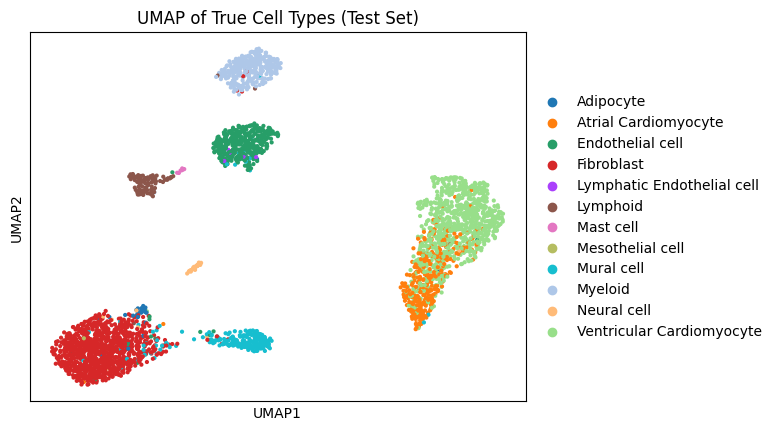

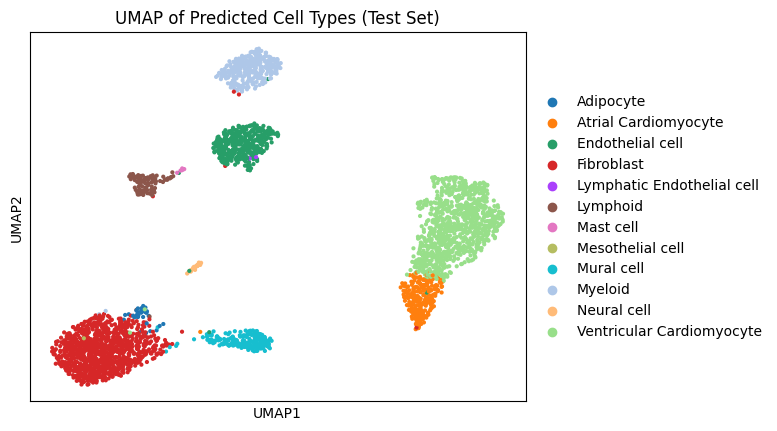

In [12]:
import scanpy as sc

# Use the cell embeddings for UMAP visualization
sc.pp.neighbors(test_adata, use_rep='cell_embeddings_from_EpiAgent')

# Compute UMAP embedding
sc.tl.umap(test_adata)

# Plot UMAP colored by true cell types
sc.pl.umap(test_adata, color=['cell_type'], title='UMAP of True Cell Types (Test Set)')

# Plot UMAP colored by predicted cell types
sc.pl.umap(test_adata, color=['predicted_cell_types'], title='UMAP of Predicted Cell Types (Test Set)')

## Performance Metrics Calculation

In [13]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score

# True labels and predicted labels for the test set
true_labels = test_adata.obs['cell_type_encoded'].values
predicted_labels = predicted_labels  # From the inference step

# Calculate performance metrics
accuracy = accuracy_score(true_labels, predicted_labels)
kappa = cohen_kappa_score(true_labels, predicted_labels)
macro_f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")

Accuracy: 0.8994
Cohen's Kappa: 0.8739
Macro F1 Score: 0.8179


## Confusion Matrix Visualization

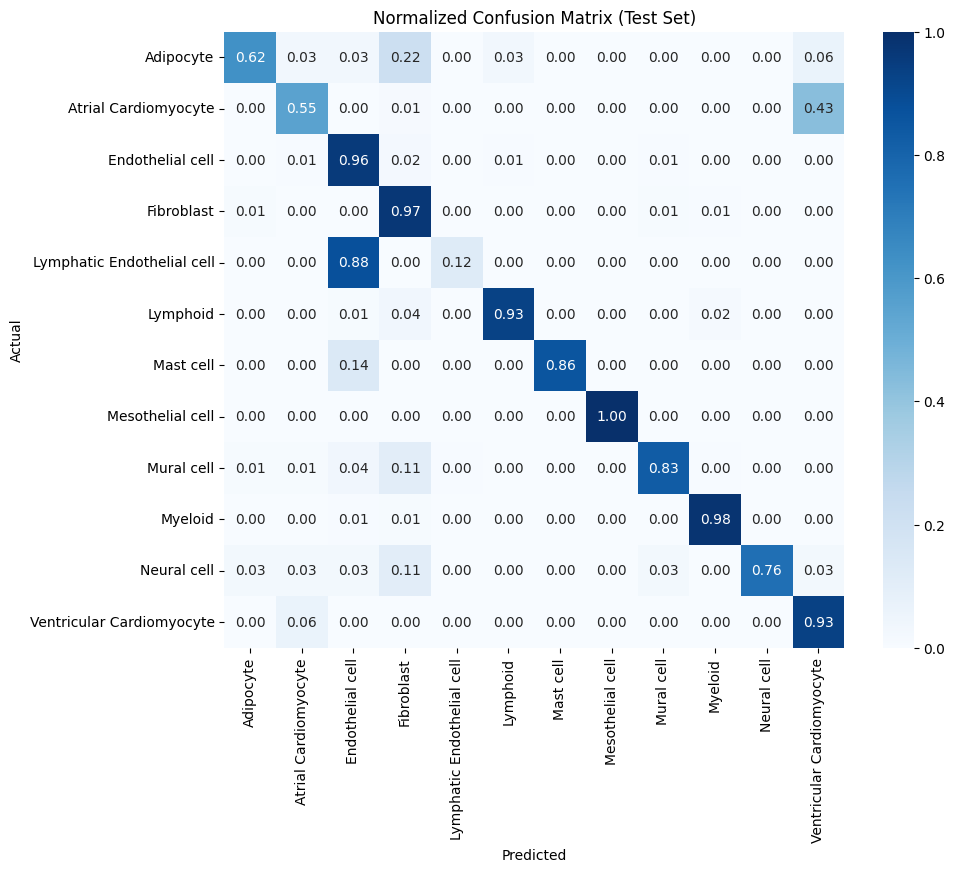

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Map encoded labels back to original cell type names
true_cell_types = test_adata.obs['cell_type'].values  # True cell type names
predicted_cell_types = test_adata.obs['predicted_cell_types'].values  # Predicted cell type names

# Create a DataFrame for the confusion matrix
confusion_df = pd.crosstab(
    pd.Series(true_cell_types, name='Actual'),
    pd.Series(predicted_cell_types, name='Predicted'),
    normalize='index'
)

# Visualize the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("Normalized Confusion Matrix (Test Set)")
plt.show()

## Save the Processed `test_adata` Object

In [15]:
# Save the test AnnData with predictions and embeddings
output_path = '../data/sample/processed_h5ad/Kanemaru2023_downsampled_10000_cells_EpiAgent_SCA_outputs.h5ad'
test_adata.write(output_path)
print(f"Processed AnnData saved at {output_path}")

Processed AnnData saved at ../data/sample/processed_h5ad/Kanemaru2023_downsampled_10000_cells_EpiAgent_SCA_outputs.h5ad
